# PRÉPARATION DONNÉES RELEVÉS BANCAIRES

## Imports et Configuration

### Imports

In [ ]:
import fitz  # PyMuPDF
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split
import os

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Configuration des chemins

In [ ]:
# Chemins du projet
BASE_DIR = Path("../data")
RAW_DIR = BASE_DIR / "raw" / "releves_bancaires"
PROCESSED_DIR = BASE_DIR / "processed" / "releves_bancaires"
ORIGINAL_DIR = PROCESSED_DIR / "original"
AUGMENTED_DIR = PROCESSED_DIR / "augmented"
FINAL_DIR = BASE_DIR / "final" / "releves_bancaires"

# Création des dossiers
for d in [RAW_DIR, PROCESSED_DIR, ORIGINAL_DIR, AUGMENTED_DIR, FINAL_DIR]:
    os.makedirs(d, exist_ok=True)

# Vérification
if not BASE_DIR.exists():
    raise FileNotFoundError(f" Dossier introuvable: {BASE_DIR}")

# Liste des PDFs
pdf_files = sorted(list(RAW_DIR.glob("*.pdf")))
print(f" {len(pdf_files)} fichiers PDF trouvés:")


 20 fichiers PDF trouvés:


## Conversion PDF => Image

In [6]:
def pdf_to_images(pdf_path, output_dir, dpi=150):
    """
    Convertit un PDF en images PNG
    
    Args:
        pdf_path: Chemin du PDF
        output_dir: Dossier de sortie
        dpi: Résolution (Dots Per Inch) (150 = bon compromis qualité/taille)
    
    Returns:
        Liste des chemins d'images créées
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    pdf_name = Path(pdf_path).stem
    doc = fitz.open(pdf_path)
    image_paths = []
    
    for page_num in range(len(doc)):
        page = doc[page_num]
        
        # Conversion avec DPI spécifié
        zoom = dpi / 72  # 72 DPI = résolution par défaut
        mat = fitz.Matrix(zoom, zoom) # on met l'echelle la page pour avoir une bonne qualité pour OCR ou vision
        pix = page.get_pixmap(matrix=mat)
        
        # Nom de fichier
        if len(doc) == 1:
            # PDF mono-page
            output_path = output_dir / f"{pdf_name}.png"
        else:
            # PDF multi-pages
            output_path = output_dir / f"{pdf_name}_page{page_num+1:02d}.png"
        
        # Sauvegarder
        pix.save(str(output_path))
        image_paths.append(output_path)
    
    doc.close()
    return image_paths


Conversion PDFs: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


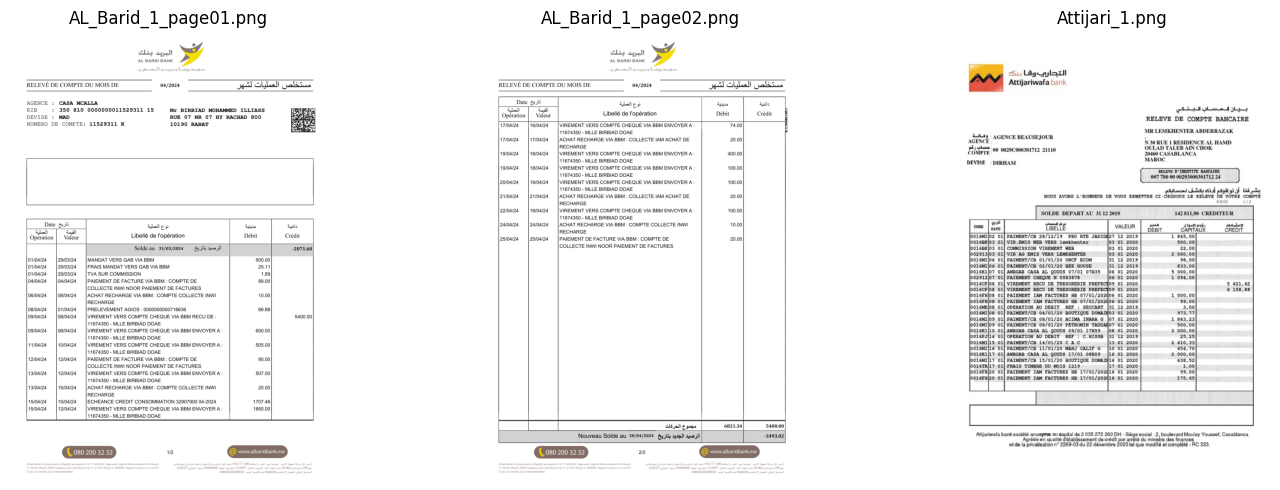

In [7]:
all_original_images = []

for pdf_path in tqdm(pdf_files, desc="Conversion PDFs"):
    images = pdf_to_images(pdf_path, ORIGINAL_DIR, dpi=150)
    all_original_images.extend(images)


# Afficher quelques exemples
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    if i < len(all_original_images):
        img = Image.open(all_original_images[i])
        ax.imshow(img)
        ax.set_title(all_original_images[i].name)
        ax.axis('off')
plt.tight_layout()
plt.show()


## Augmentation des images

### Classe qui contient les techniques d'augmentation

In [8]:
class ImageAugmentor:
    """Classe pour augmenter les images de factures"""
    
    def __init__(self, seed=42):
        self.seed = seed
        random.seed(seed)
    
    def rotate(self, image, angle_range=(-10, 10)):
        """Rotation aléatoire (scan non parfait)"""
        angle = random.uniform(*angle_range)
        return image.rotate(angle, fillcolor='white', expand=False)
    
    def add_noise(self, image, intensity=0.02):
        """Ajout de bruit gaussien (qualité scan/photo)"""
        img_array = np.array(image).astype(np.float32)
        noise = np.random.normal(0, intensity * 255, img_array.shape)
        noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy_img)
    
    def adjust_brightness(self, image, factor_range=(0.8, 1.2)):
        """Ajustement luminosité (conditions éclairage)"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Brightness(image)
        return enhancer.enhance(factor)
    
    def adjust_contrast(self, image, factor_range=(0.8, 1.2)):
        """Ajustement contraste (qualité impression)"""
        factor = random.uniform(*factor_range)
        enhancer = ImageEnhance.Contrast(image)
        return enhancer.enhance(factor)
    
    def add_blur(self, image, radius_range=(0.5, 2.0)):
        """Ajout de flou (photo non nette)"""
        radius = random.uniform(*radius_range)
        return image.filter(ImageFilter.GaussianBlur(radius))
    
    
    def perspective_transform(self, image, intensity=0.1):
        """Transformation perspective (photo smartphone)"""
        img_array = np.array(image)
        h, w = img_array.shape[:2]
        
        # Points source (coins de l'image)
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        
        # Points destination (légèrement déformés)
        offset = int(min(h, w) * intensity)
        dst_points = np.float32([
            [random.randint(0, offset), random.randint(0, offset)],
            [w - random.randint(0, offset), random.randint(0, offset)],
            [w - random.randint(0, offset), h - random.randint(0, offset)],
            [random.randint(0, offset), h - random.randint(0, offset)]
        ])
        
        # Appliquer transformation
        matrix = cv2.getPerspectiveTransform(src_points, dst_points)
        warped = cv2.warpPerspective(img_array, matrix, (w, h), 
                                      borderMode=cv2.BORDER_CONSTANT,
                                      borderValue=(255, 255, 255))
        return Image.fromarray(warped)
    
    def augment_pipeline(self, image, num_transforms=3):
        """
        Pipeline complet d'augmentation avec transformations aléatoires
        
        Args:
            image: Image PIL
            num_transforms: Nombre de transformations à appliquer
        """
        transforms = [
            self.rotate,
            self.add_noise,
            self.adjust_brightness,
            self.adjust_contrast,
            self.add_blur,
            self.perspective_transform
        ]
        
        # Sélectionner aléatoirement num_transforms
        selected = random.sample(transforms, min(num_transforms, len(transforms)))
        
        augmented = image.copy()
        for transform in selected:
            augmented = transform(augmented)
        
        return augmented


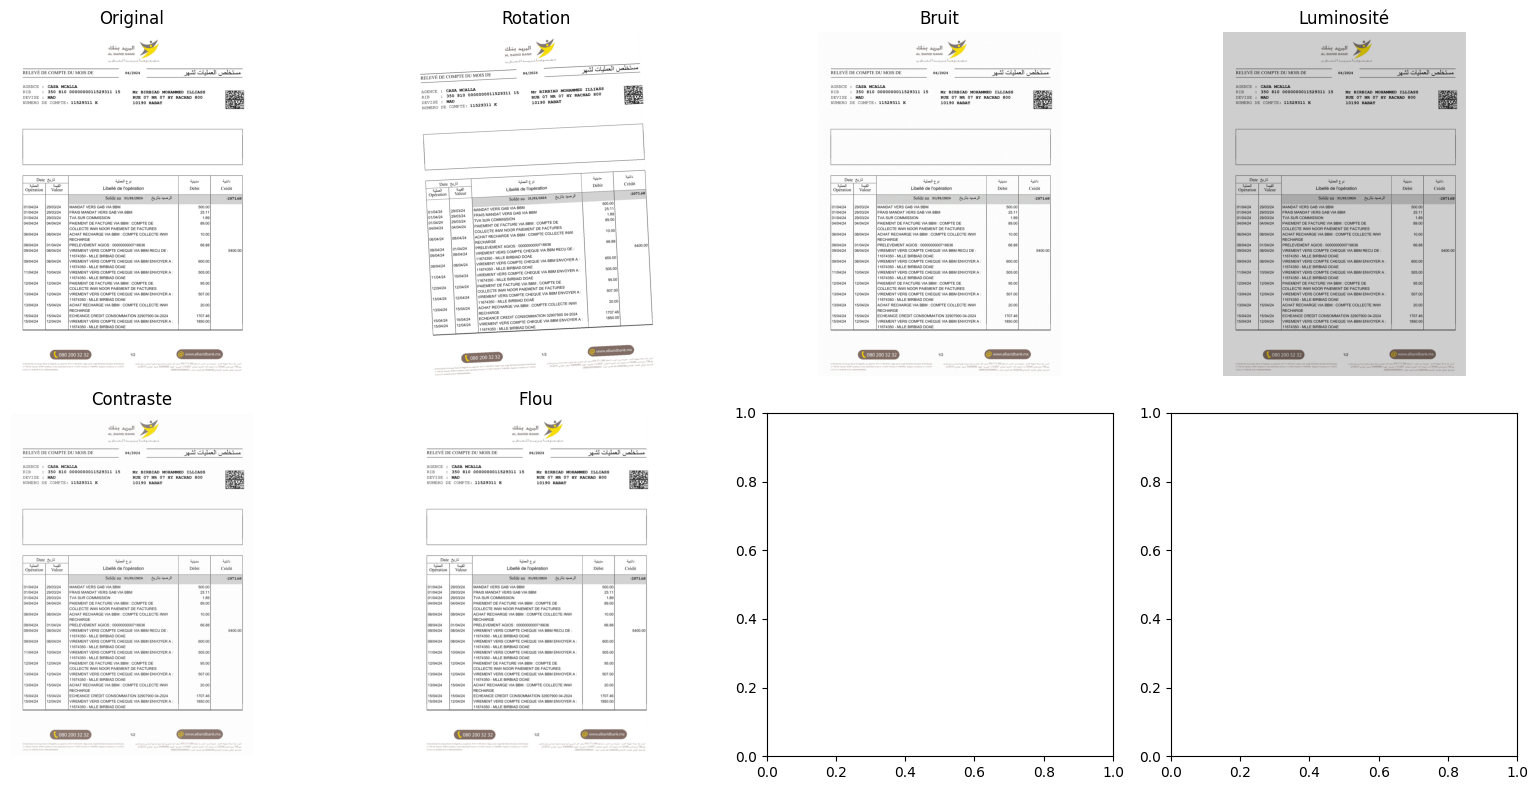

In [9]:
# Test des augmentations
augmentor = ImageAugmentor(seed=SEED)
test_img = Image.open(all_original_images[0])

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Image originale
axes[0].imshow(test_img)
axes[0].set_title("Original")
axes[0].axis('off')

# Différentes augmentations
aug_methods = [
    ("Rotation", lambda img: augmentor.rotate(img)),
    ("Bruit", lambda img: augmentor.add_noise(img)),
    ("Luminosité", lambda img: augmentor.adjust_brightness(img)),
    ("Contraste", lambda img: augmentor.adjust_contrast(img)),
    ("Flou", lambda img: augmentor.add_blur(img)),
]

for i, (name, method) in enumerate(aug_methods, 1):
    axes[i].imshow(method(test_img))
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Génération du Dataset Augmenté

In [10]:
# Configuration augmentation
NUM_AUGMENTATIONS_PER_IMAGE = 2  # 2x par image (ratio conservateur)
NUM_TRANSFORMS_PER_AUG = 3        # 3 transformations aléatoires par image

augmentor = ImageAugmentor(seed=SEED)

for img_path in tqdm(all_original_images, desc="Augmentation"):
    img = Image.open(img_path).convert('RGB')
    base_name = img_path.stem
    
    # Générer augmentations
    for i in range(NUM_AUGMENTATIONS_PER_IMAGE):
        augmented = augmentor.augment_pipeline(img, num_transforms=NUM_TRANSFORMS_PER_AUG)
        
        # Sauvegarder
        output_path = AUGMENTED_DIR / f"{base_name}_aug_{i+1:03d}.png"
        augmented.save(output_path)


Augmentation: 100%|██████████| 35/35 [00:58<00:00,  1.67s/it]


### Nombre totale des images

In [11]:
all_images = list(ORIGINAL_DIR.glob("*.png")) + list(AUGMENTED_DIR.glob("*.png"))

print(f"Total: {len(all_images)}")


Total: 105


## Split data

In [12]:
# Split stratifié: 70% train, 15% val, 15% test
train_images, temp_images = train_test_split(
    all_images, 
    test_size=0.3, 
    random_state=SEED
)

val_images, test_images = train_test_split(
    temp_images, 
    test_size=0.5, 
    random_state=SEED
)


print(f"Train: {len(train_images)}")
print(f"Val:   {len(val_images)}")
print(f"Test:  {len(test_images)}")

# Copier dans les dossiers finaux
splits = {
    'train': train_images,
    'val': val_images,
    'test': test_images
}

for split_name, images in splits.items():
    split_dir = FINAL_DIR / split_name
    split_dir.mkdir(parents=True, exist_ok=True)
    
    for img_path in tqdm(images, desc=f"Copie {split_name}"):
        shutil.copy2(img_path, split_dir / img_path.name)


Train: 73
Val:   16
Test:  16


Copie test: 100%|██████████| 16/16 [00:00<00:00, 773.51it/s]
